# Problem Statement 
- You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Reading the Data
data = pd.read_csv('beer_data.csv')

In [3]:
data.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [4]:
data.shape

(475984, 3)

## Data Preparation

In [5]:
# Checking null values
data.isnull().sum()

beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64

In [6]:
# Its better to remove the null values as they are seems to be less from the overall data
data = data.dropna()

In [7]:
# Identifying the count and percentage of ratings for different beers
df_count = data.groupby('beer_beerid').agg({'review_overall': 'count'}).rename(columns= {'review_overall':'reviews_count'}).reset_index()
df_count['Percentage'] = (df_count['reviews_count']*100)/(df_count['reviews_count'].sum())

In [8]:
df_count.head()

,beer_beerid,reviews_count,Percentage
0,3,2,0.000420
1,4,6,0.001261
2,5,113,0.023745
3,6,253,0.053164
4,7,206,0.043288


In [9]:
df_count.shape

(40304, 3)

In [10]:
# Finding the percentage of the count from total reviews in descending order
df_count.sort_values(by='Percentage',ascending=False).head()

,beer_beerid,reviews_count,Percentage
1574,2093,987,0.207403
338,412,975,0.204882
1427,1904,904,0.189962
818,1093,848,0.178195
78,92,818,0.171891


In [11]:
# Idenitfying the stats
df_count.describe()

,beer_beerid,reviews_count,Percentage
count,40304.000000,40304.000000,40304.000000
mean,36973.166460,11.807364,0.002481
std,22544.756432,42.086328,0.008844
min,3.000000,1.000000,0.000210
25%,16879.750000,1.000000,0.000210
50%,37366.500000,2.000000,0.000420
75%,56233.500000,5.000000,0.001051
max,77317.000000,987.000000,0.207403


- From above describe stats, 50% of the beer_id's has less than 2 reviews. 75% of the beer id's has less than 5 reviews.
- We can not recommend to some one with single review. 
- We have to aggregate the data by beer_id and user_id

In [12]:
#Checking duplicates from the data based on beer_beerid and review_profilename columns
data.duplicated(['beer_beerid','review_profilename']).sum()

1422

- There are 1424 duplicate entries are there in the dataset. It's better to remove them

In [13]:
# Dropping duplicate values by just keeping one value which is in the first place
data = data.drop_duplicates(['beer_beerid','review_profilename'],keep='first')
data.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [14]:
data.shape

(474462, 3)

## Choose only those beers that have at least N number of reviews.

1.Figure out an appropriate value of N using EDA. This may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.

- So, here we have to set the threshold of N to eliminate extremely low number of ratings for beer.
- We have to consider beers which has low number of ratings and users who gave less number of ratings as well

In [16]:
beer_n_value = data.groupby('beer_beerid').agg({'review_overall':'count'}).reset_index()

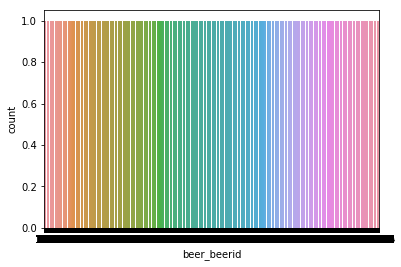

In [19]:
import seaborn as sns
sns.countplot(data=beer_n_value,x='beer_beerid')

- The above count plot seems to be messy. So, let's plot histogram using value_counts function

Text(0.5,0,'Ratings Count')

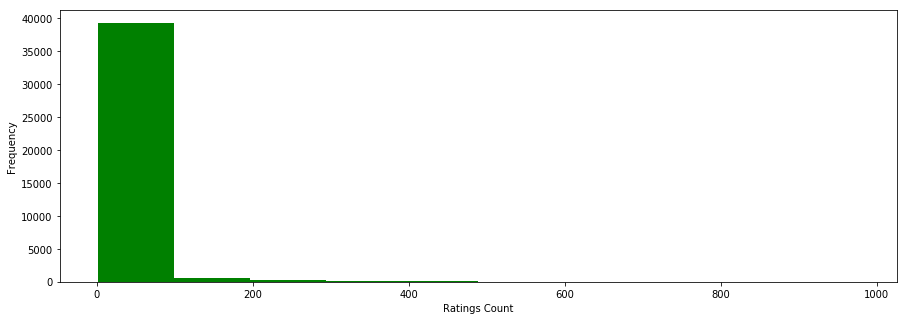

In [28]:
# Taking aggregate level of beer review counts
plt.figure(figsize=(15,5))
data['beer_beerid'].value_counts().plot.hist(color = "green")
plt.xlabel('Ratings Count')

- From the above graph most of the beers has ratings of 0-200 and there is very high in number between 0-150

In [24]:
# Extracting the beer_id's which has count less than or equals to 150
beer_count = pd.DataFrame(data['beer_beerid'].value_counts())
beer_count = beer_count[beer_count <=150]

Text(0.5,0,'Reviews')

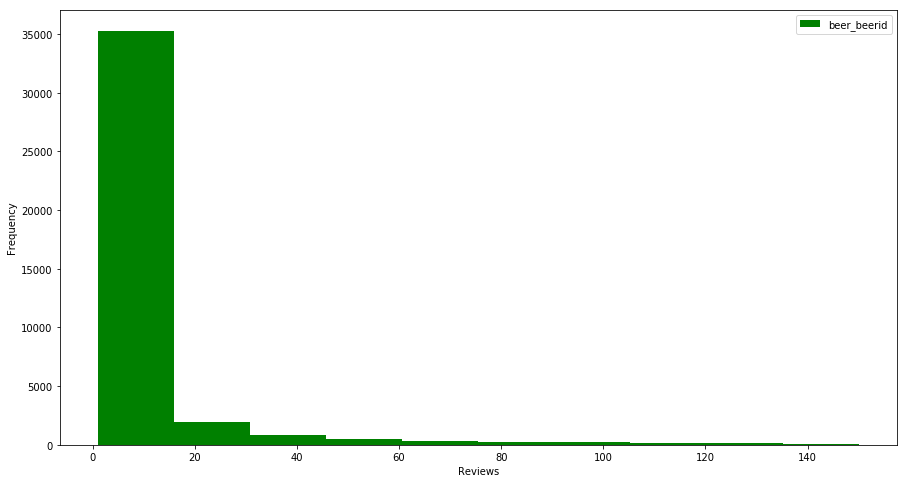

In [33]:
# Plotting the graph of beer_id's which has less than 150 count
beer_count.plot.hist(color='green',figsize=(15,8))
plt.xlabel('Reviews')

- From the above graph there are very high number of beers which has only 0-15  ratings
- 15-30 has second highest count of ratings in the data
- **As lower number of beer ratings doesn't give us good value to recommend to others. So, we can set threshold of N<=80 to be consider as extremely low number of ratings**

In [34]:
# Removing extremely low values from the beer ratings
beer_new  = data.groupby('beer_beerid')['review_overall'].count().reset_index()
beer_new = beer_new[beer_new['review_overall'] >=80].rename(columns={'review_overall':'beer_reviews'})

In [89]:
beer_new.head()

,beer_beerid,beer_reviews
2,5,113
3,6,253
4,7,205
7,10,218
14,17,241


Text(0.5,0,'Reviews')

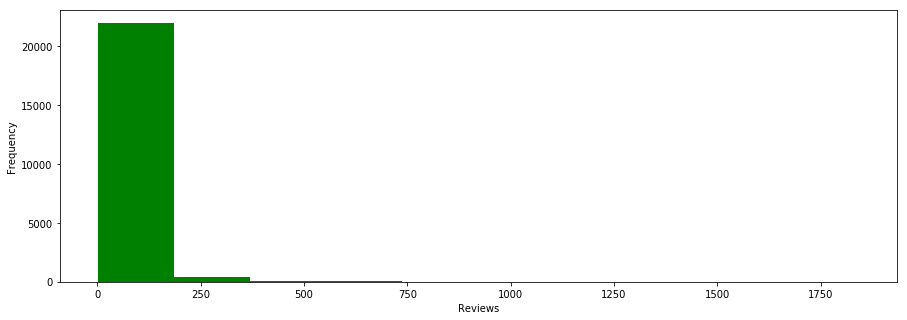

In [36]:
# Now checking reviews count at user level
plt.figure(figsize=(15,5))
data['review_profilename'].value_counts().plot.hist(color='green')
plt.xlabel('Reviews')

- From the above graph majority of the user reviews are less than 250.

In [37]:
# Seperating Users who has less than or equal to 250 reviews
user_reviews_count = pd.DataFrame(data['review_profilename'].value_counts())
user_reviews_count = user_reviews_count[user_reviews_count <=250]

Text(0.5,0,'Reviews')

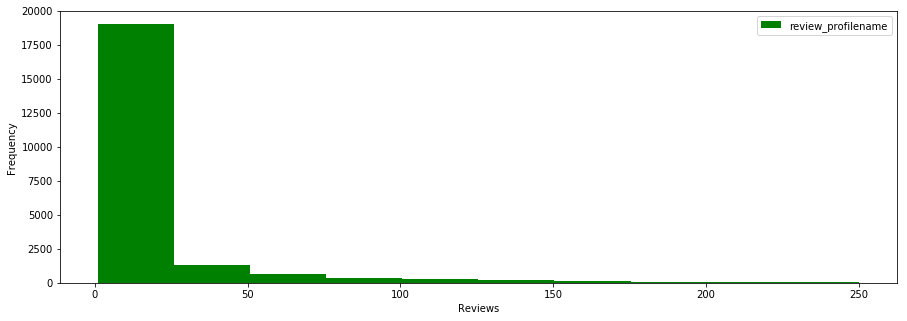

In [52]:
# Plotting the graph to identify the users trend in ratings count
user_reviews_count.plot.hist(color='green',figsize=(15,5))
plt.xlabel('Reviews')

- From the above graphs we can see that there are users who has given only <=50 reviews as well. We have to consider it as an extreme value as well 

In [41]:
# Removing extremely low values from the user ratings
user_new = data.groupby('review_profilename')['review_overall'].count().reset_index()
user_new = user_new[user_new['review_overall'] >=50].rename(columns={'review_overall':'user_reviews'})

In [42]:
user_new.head()

,review_profilename,user_reviews
28,1759Girl,73
39,1fastz28,124
83,3Vandoo,101
92,4000qtrap,66
99,4DAloveofSTOUT,72


In [43]:
# Creating final dataframe after applying the filters to removing the extreme values of beer by setting N>=80 and user by N>= 50
final_data = data.merge(beer_new,how='inner',on='beer_beerid')
final_data = final_data.merge(user_new,how='inner',on='review_profilename')

In [44]:
final_data.shape

(167339, 5)

In [45]:
final_data.head()

,beer_beerid,review_profilename,review_overall,beer_reviews,user_reviews
0,436,Brent,3.0,127,518
1,10784,Brent,4.0,119,518
2,16074,Brent,4.0,431,518
3,33644,Brent,4.0,261,518
4,34146,Brent,4.0,347,518


## Data Exploration

- Visualise the rating values and notice:

 **1. Identifying the unique values of ratings**

In [27]:
# Identifying the unique values of ratings
final_data['review_overall'].value_counts()

4.0    64214
4.5    38569
3.5    30146
3.0    14677
5.0    10041
2.5     4860
2.0     3141
1.5      925
1.0      766
Name: review_overall, dtype: int64

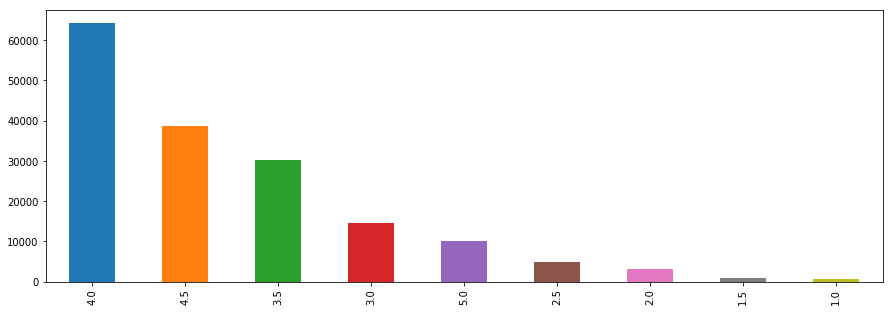

In [50]:
# Plotting ratings count
final_data['review_overall'].value_counts().plot.bar(figsize=(15,5))

- The above are the different ratings available from the dataset
- Where 5 is being the best rating and 0 is the worst rating
- Most of the users are given with 4 rating

- **i.Finding average Beer Ratings**

In [66]:
# Finding Average beer ratings
avg_beer_rating = final_data.groupby('beer_beerid').agg({'review_overall':'mean'}).rename(columns={'review_overall':'average_rating'})

Text(0,0.5,'Average Ratings')

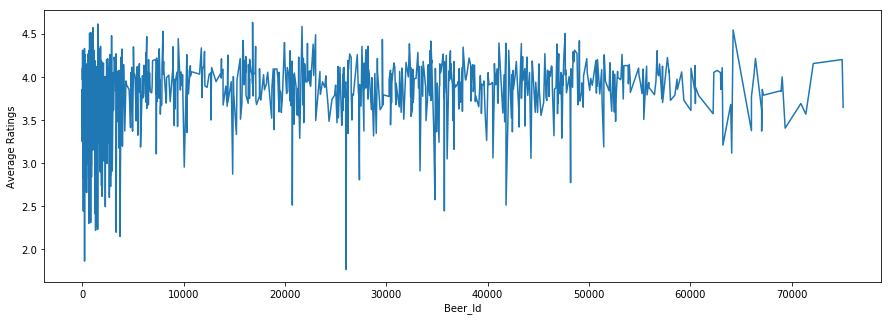

In [75]:
# Plotting graph for average beer ratings
plt.figure(figsize=(15,5))
plt.plot(avg_beer_rating)
plt.xlabel('Beer_Id')
plt.ylabel('Average Ratings')

- The above graph seems to be bit messy for all the beers but if we observe the above graph it is evident that average ratings of most of the beer product is lies between 3.5 to 4

In [67]:
# Finding the top 10 beers average
avg_beer_rating.sort_values(by='average_rating',ascending=False).head(10)

,average_rating
beer_beerid,
16814,4.631944
1545,4.614224
21690,4.586207
1062,4.571429
64228,4.544776
7971,4.528986
857,4.513605
731,4.508242
47658,4.504425


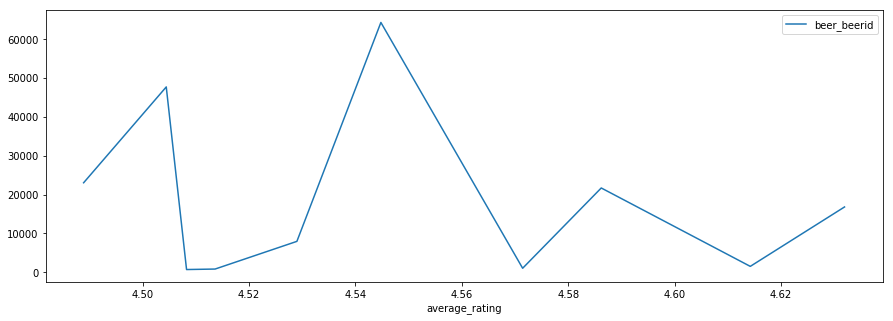

In [74]:
# Plotting the top 10 beers average
avg_beer = avg_beer_rating.sort_values(by='average_rating',ascending=False).head(10)
avg_beer.reset_index().plot(y='beer_beerid', x='average_rating',figsize=(15,5))

- So, for top 10 Beers average lies between 4.5 to 4.6

**ii)The average user ratings:**

In [78]:
# Finding Average user ratings
avg_user_rating = final_data.groupby('review_profilename').agg({'review_overall':'mean'}).rename(columns={'review_overall':'average_rating'})

In [79]:
avg_user_rating.head()

,average_rating
review_profilename,
1759Girl,3.777778
1fastz28,3.913333
3Vandoo,3.939394
4000qtrap,3.781250
4DAloveofSTOUT,3.960526


Text(0,0.5,'Average Ratings')

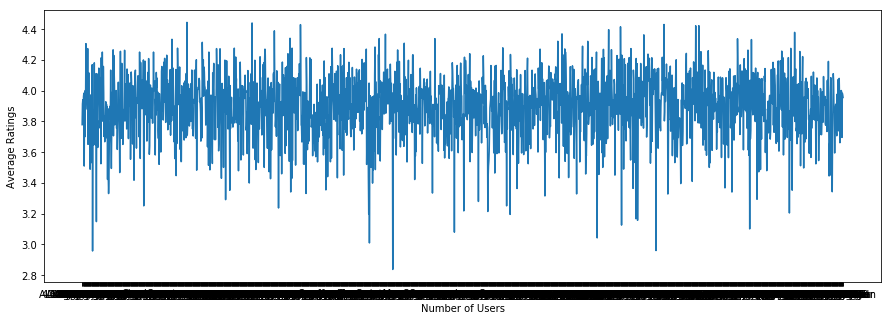

In [80]:
# Plotting average users rating
plt.figure(figsize=(15,5))
plt.plot(avg_user_rating['average_rating'])
plt.xlabel('Number of Users')
plt.ylabel('Average Ratings')

- From the above graph most of the users has average rating of 3.8 to 4.1

In [81]:
# Finding the top 10 Users average
avg_user_rating.sort_values(by='average_rating',ascending=False).head(10)

,average_rating
review_profilename,
EnojysAnyBeer,4.443299
KickbacksSteve,4.439394
mempath,4.429577
OldSock,4.428571
nsmit17,4.421569
noelcb,4.421053
jtw5877,4.414634
jjboesen,4.395833
MattyG85,4.388158


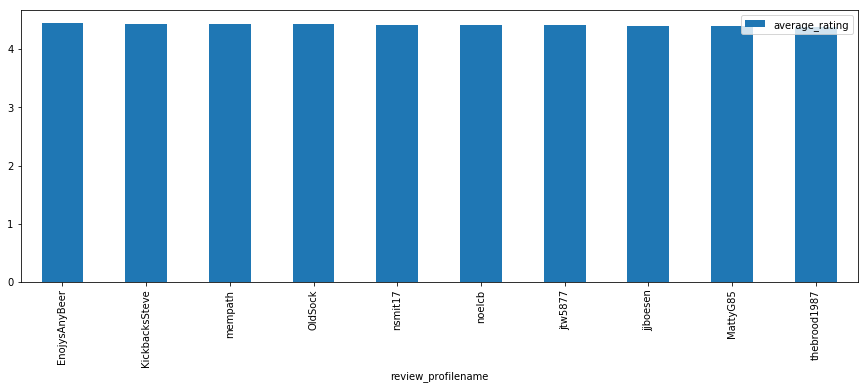

In [86]:
# Plotting the top 10 users average
avg_user = avg_user_rating.sort_values(by='average_rating',ascending=False).head(10)
avg_user.plot.bar(figsize=(15,5))

- So, from the above graph, top 10 users has average rating greater than 4.3

*** iii.The average number of ratings given to the beers***

In [91]:
# Finding Average number of ratings given to the beer
avg_no_beer_rating = final_data.groupby('beer_beerid').agg({'beer_reviews':'mean'}).reset_index()

In [92]:
avg_no_beer_rating.sort_values(by='beer_reviews',ascending=False).head(10)

,beer_beerid,beer_reviews
486,2093,977
140,412,966
458,1904,902
297,1093,840
29,92,812
620,4083,798
100,276,788
707,7971,778
26,88,755
285,1013,750


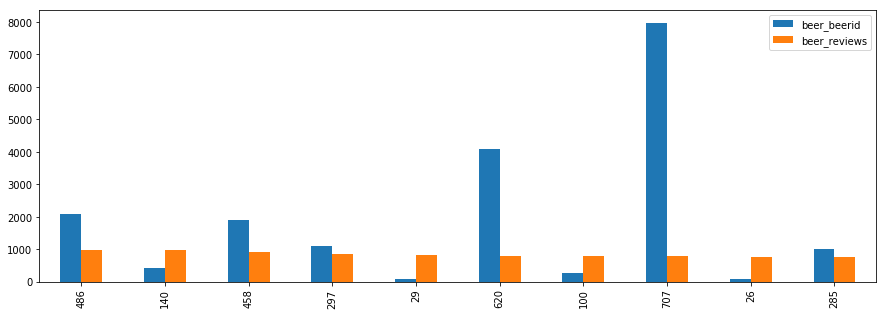

In [94]:
# Plotting the top 10 beers average
avg_no_beer = avg_no_beer_rating.sort_values(by='beer_reviews',ascending=False).head(10)
avg_no_beer.plot.bar(figsize=(15,5))

- From the above graph, all the top 10 Beers has average ratings  greater than 750 and less than 1000

** iv)The average number of ratings given by the users**

In [95]:
# Finding Average number of ratings given by the user
user_ratings_count = final_data.groupby('review_profilename').agg({'user_reviews':'mean'}).reset_index()

In [96]:
user_ratings_count.sort_values(by='user_reviews',ascending=False).head(10)

,review_profilename,user_reviews
1765,northyorksammy,1842
1686,mikesgroove,1373
169,BuckeyeNation,1336
857,Thorpe429,1072
194,ChainGangGuy,1046
603,NeroFiddled,1027
2153,womencantsail,1013
1112,brentk56,992
915,WesWes,976
662,Phyl21ca,973


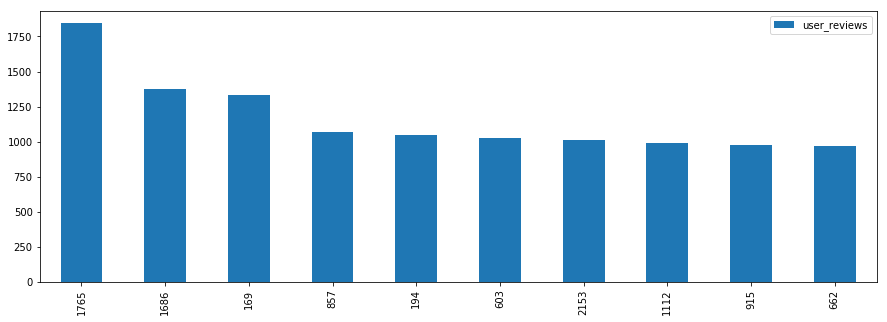

In [97]:
# Plotting the top 10 Users average
avg_no_user = user_ratings_count.sort_values(by='user_reviews',ascending=False).head(10)
avg_no_user.plot.bar(figsize=(15,5))

- From above Top 10 users has average ratings greater than 973 and less than 1800

# Building Recommendation Model

In [98]:
# Dividing Data into Train and Test 
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.30, random_state=42)

In [99]:
print(train.shape)
print(test.shape)

(117137, 5)
(50202, 5)


## Building User based Recommendation Model

In [100]:
# Applying pivot to convert  beer_id into features
df_beer_features = train.pivot(index='review_profilename',columns='beer_beerid',values='review_overall').fillna(0)

In [101]:
df_beer_features.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3Vandoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4000qtrap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
4DAloveofSTOUT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Copy train and test dataset
- These dataset will be used for prediction and evaluation.

- Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. The beers not rated by user is marked as 1 for prediction.
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [102]:
# Taking copy of train and test for later use
dummy_train = train.copy()
dummy_test = test.copy()

In [103]:
dummy_train.head()

,beer_beerid,review_profilename,review_overall,beer_reviews,user_reviews
165463,2533,Dawkfan,3.5,197,56
57166,1171,endincolorado,4.0,121,83
110012,19960,Buebie,4.0,581,191
24794,53980,GbVDave,5.0,87,437
34344,1341,Avagadro,3.0,139,105


In [104]:
# Replacing Users ratings with 0  if he really given and replacing with 1 if the user didnt give any ratings 
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)

# Replacing users ratings with 1 if he really given the ratings and 0 if the user didn't give any ratings
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [105]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(index='review_profilename',columns='beer_beerid',values='review_overall').fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(index='review_profilename', columns='beer_beerid', values='review_overall').fillna(0)

In [106]:
dummy_train.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1fastz28,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3Vandoo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4000qtrap,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4DAloveofSTOUT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [107]:
dummy_test.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3Vandoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4000qtrap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4DAloveofSTOUT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User Similarity Matrix
- Using Cosine Similarity

In [108]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.04525162 0.         ... 0.01509033 0.         0.03839389]
 [0.04525162 1.         0.0193894  ... 0.08396256 0.15363753 0.02677377]
 [0.         0.0193894  1.         ... 0.0239785  0.         0.06722154]
 ...
 [0.01509033 0.08396256 0.0239785  ... 1.         0.06530604 0.09180359]
 [0.         0.15363753 0.         ... 0.06530604 1.         0.        ]
 [0.03839389 0.02677377 0.06722154 ... 0.09180359 0.         1.        ]]


In [109]:
user_correlation.shape

(2186, 2186)

- We have to calculate Cosine Similarity(a.b/|a|.|b|) to identify the similarity between the users, but we have changed our data where ever user gave the ratings we have changed it to 0. So it is not correct to compare with other users with wrong data. So we will use Adjusted Cosine similarity to overcome this  

### Using adjusted Cosine
- Here taking the same train data as it is by not removing the NaN values and calculating the mean only for the beers rated by the user

In [110]:
beer_features = train.pivot(index='review_profilename', columns='beer_beerid',values='review_overall')
beer_features.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3Vandoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000qtrap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN
4DAloveofSTOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Normalising the rating of the movie for each user around 0 mean.
#Since users may give ratings as per their mood. So we have to normalise without creating any bias
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [112]:
df_subtracted.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,NaN,NaN,0.059322,NaN,NaN,NaN,NaN,1.059322,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3Vandoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000qtrap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.72,NaN
4DAloveofSTOUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [113]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.01566798  0.         ...  0.0207163   0.
  -0.00276496]
 [ 0.01566798  1.          0.01617669 ...  0.01980662  0.07442956
   0.02116614]
 [ 0.          0.01617669  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.0207163   0.01980662  0.         ...  1.          0.
   0.04490402]
 [ 0.          0.07442956  0.         ...  0.          1.
   0.        ]
 [-0.00276496  0.02116614  0.         ...  0.04490402  0.
   1.        ]]


### Prediction
- Doing the prediction for the users which are positively related with other users, and not the users which are negatively related. As we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0

In [114]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.01566798, 0.        , ..., 0.0207163 , 0.        ,
        0.        ],
       [0.01566798, 1.        , 0.01617669, ..., 0.01980662, 0.07442956,
        0.02116614],
       [0.        , 0.01617669, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0207163 , 0.01980662, 0.        , ..., 1.        , 0.        ,
        0.04490402],
       [0.        , 0.07442956, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.02116614, 0.        , ..., 0.04490402, 0.        ,
        1.        ]])

- Rating predicted by the user (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating (as present in the rating dataset).

In [115]:
# Calculating the dot product with user correlations and beer features
user_predicted_ratings = np.dot(user_correlation, beer_features.fillna(0))
user_predicted_ratings

array([[4.66121719, 6.30071558, 5.36220969, ..., 5.21448347, 4.47723947,
        2.54932578],
       [5.20243235, 9.77852625, 6.10784289, ..., 7.65241704, 3.12061904,
        3.82517784],
       [4.39652835, 4.67059766, 5.54886153, ..., 3.60552843, 1.5536166 ,
        1.77754243],
       ...,
       [2.87949561, 8.05006256, 5.30250549, ..., 8.33826236, 5.3684001 ,
        2.50851975],
       [7.02357713, 6.19116595, 4.47860576, ..., 5.12743508, 2.67475774,
        2.46797342],
       [3.72843412, 7.59272918, 5.42462533, ..., 6.59913049, 3.03216959,
        1.72480819]])

In [116]:
user_predicted_ratings.shape

(2186, 1328)

- Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero.

In [117]:
# Multiplying ratings score with the beers not rated by users
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,4.661217,6.300716,5.362210,6.348159,5.235114,4.492853,10.843545,10.156226,15.384407,22.063380,...,3.068249,2.527021,2.939585,3.956438,2.531925,2.051825,1.808643,5.214483,4.477239,2.549326
1fastz28,5.202432,9.778526,6.107843,0.000000,8.395747,5.728804,17.788123,9.535288,0.000000,23.148868,...,3.497684,2.935879,3.541807,3.077632,3.507088,3.040000,2.145147,7.652417,3.120619,3.825178
3Vandoo,4.396528,4.670598,5.548862,5.817280,7.673837,3.432665,10.814853,10.425591,15.880421,0.000000,...,2.725318,2.264747,2.583321,1.517065,1.713618,1.735265,1.936318,3.605528,1.553617,1.777542
4000qtrap,2.215181,5.247200,2.907386,4.514662,3.781879,4.152490,9.667975,7.630548,12.005732,12.922092,...,3.033685,1.242097,3.320564,2.413098,2.844411,2.131118,1.370820,3.686928,0.000000,2.102922
4DAloveofSTOUT,1.956836,4.252740,1.908971,4.435036,3.108898,1.921899,7.622120,5.602236,9.981000,14.310524,...,3.979057,1.812783,3.630235,2.920791,2.256832,2.549392,2.382381,6.464336,3.815014,2.332783


### Finding the top 5 recommendation for the user 1

In [118]:
user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
412     32.340706
731     28.507251
1093    28.232491
1005    26.901740
1708    26.106430
Name: 1fastz28, dtype: float64

### Determine how similar the first ten users are with each other and visualize it

In [119]:
# Extracting First 10 Users with first 10 beers Information
first_10_user = user_final_rating.iloc[:10,:10]
first_10_user

beer_beerid,5,6,7,10,17,19,30,31,33,34
review_profilename,,,,,,,,,,
1759Girl,4.661217,6.300716,5.362210,6.348159,5.235114,4.492853,10.843545,10.156226,15.384407,22.063380
1fastz28,5.202432,9.778526,6.107843,0.000000,8.395747,5.728804,17.788123,9.535288,0.000000,23.148868
3Vandoo,4.396528,4.670598,5.548862,5.817280,7.673837,3.432665,10.814853,10.425591,15.880421,0.000000
4000qtrap,2.215181,5.247200,2.907386,4.514662,3.781879,4.152490,9.667975,7.630548,12.005732,12.922092
4DAloveofSTOUT,1.956836,4.252740,1.908971,4.435036,3.108898,1.921899,7.622120,5.602236,9.981000,14.310524
99bottles,3.765462,8.781741,5.370212,9.828090,10.783089,7.455919,16.222064,15.283164,0.000000,0.000000
9InchNails,5.252216,9.284718,6.637417,8.592966,8.023337,6.753353,16.533103,12.551676,16.906487,22.191500
AChamberlain,3.313255,6.120024,3.595998,4.017988,4.418684,3.383164,9.566115,5.132101,12.546987,11.626972
ADR,9.106412,16.758292,10.339384,12.682613,14.983772,9.634218,24.754755,18.927820,28.361859,35.667472


In [122]:
# Taking transpose of the above dataframe
first_10_user_T = first_10_user.T
first_10_user_T

review_profilename,1759Girl,1fastz28,3Vandoo,4000qtrap,4DAloveofSTOUT,99bottles,9InchNails,AChamberlain,ADR,ADZA
beer_beerid,,,,,,,,,,
5,4.661217,5.202432,4.396528,2.215181,1.956836,3.765462,5.252216,3.313255,9.106412,5.483179
6,6.300716,9.778526,4.670598,5.247200,4.252740,8.781741,9.284718,6.120024,16.758292,9.802944
7,5.362210,6.107843,5.548862,2.907386,1.908971,5.370212,6.637417,3.595998,10.339384,7.350814
10,6.348159,0.000000,5.817280,4.514662,4.435036,9.828090,8.592966,4.017988,12.682613,10.271859
17,5.235114,8.395747,7.673837,3.781879,3.108898,10.783089,8.023337,4.418684,14.983772,8.604031
19,4.492853,5.728804,3.432665,4.152490,1.921899,7.455919,6.753353,3.383164,9.634218,5.135851
30,10.843545,17.788123,10.814853,9.667975,7.622120,16.222064,16.533103,9.566115,24.754755,21.200894
31,10.156226,9.535288,10.425591,7.630548,5.602236,15.283164,12.551676,5.132101,18.927820,0.000000
33,15.384407,0.000000,15.880421,12.005732,9.981000,0.000000,16.906487,12.546987,28.361859,19.612913


In [123]:
# Finding correlation matrix
first_10_user_T.corr()

review_profilename,1759Girl,1fastz28,3Vandoo,4000qtrap,4DAloveofSTOUT,99bottles,9InchNails,AChamberlain,ADR,ADZA
review_profilename,,,,,,,,,,
1759Girl,1.000000,0.561662,0.068235,0.944145,0.986805,-0.408596,0.963366,0.893749,0.963835,0.774275
1fastz28,0.561662,1.000000,-0.374329,0.490220,0.560703,0.114019,0.622121,0.423421,0.601796,0.502204
3Vandoo,0.068235,-0.374329,1.000000,0.308836,0.098987,0.243655,0.186376,0.352848,0.190377,0.070073
4000qtrap,0.944145,0.490220,0.308836,1.000000,0.959246,-0.228675,0.980614,0.955261,0.971418,0.782829
4DAloveofSTOUT,0.986805,0.560703,0.098987,0.959246,1.000000,-0.346211,0.979323,0.922608,0.982157,0.830020
99bottles,-0.408596,0.114019,0.243655,-0.228675,-0.346211,1.000000,-0.195442,-0.347203,-0.262722,-0.366959
9InchNails,0.963366,0.622121,0.186376,0.980614,0.979323,-0.195442,1.000000,0.929681,0.987974,0.817522
AChamberlain,0.893749,0.423421,0.352848,0.955261,0.922608,-0.347203,0.929681,1.000000,0.949998,0.875796
ADR,0.963835,0.601796,0.190377,0.971418,0.982157,-0.262722,0.987974,0.949998,1.000000,0.829610


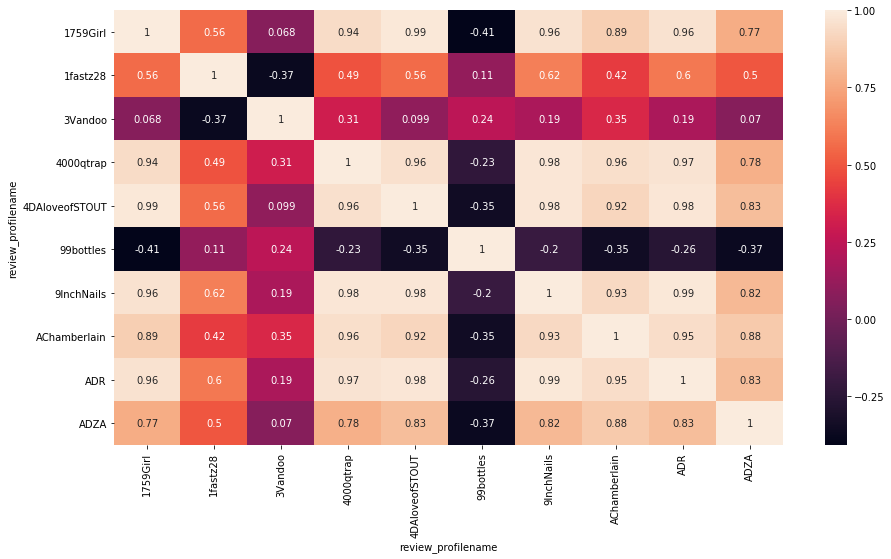

In [124]:
# Plotting correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(first_10_user_T.corr(method ='pearson'),annot=True)
plt.show()

**From the above correlation plot:**
    - User 1759Girl is highly  positively correlated with 4000qtrap,4DAloveofSTOUT,9InchNails,AChamberlain,ADR and ADZA with more than 70% correlation
    - User 1759Girl is negatively correlated with user 99bottles
    

### Item Based Similarity

- Using Correlation

- Taking the transpose of the rating matrix to normalize the rating around the mean for different beer ID. In the user based similarity, we had taken mean for each user intead of each beer.

In [125]:
# Finding Item based similarity
beer_features = train.pivot(index='review_profilename',columns='beer_beerid',values='review_overall').T

beer_features.head()

review_profilename,1759Girl,1fastz28,3Vandoo,4000qtrap,4DAloveofSTOUT,99bottles,9InchNails,AChamberlain,ADR,ADZA,...,zdk9,zeff80,zeledonia,zerk,zhanson88,zimm421,zoolzoo,zoso1967,zoso493,zrab11
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# Normalising the beer rating for each beer
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [127]:
df_subtracted.head()

review_profilename,1759Girl,1fastz28,3Vandoo,4000qtrap,4DAloveofSTOUT,99bottles,9InchNails,AChamberlain,ADR,ADZA,...,zdk9,zeff80,zeledonia,zerk,zhanson88,zimm421,zoolzoo,zoso1967,zoso493,zrab11
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.079365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.701681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,0.116822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.543478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value.

In [128]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -2.62842691e-02  1.81286965e-03 ...  0.00000000e+00
   2.22808172e-02  1.66656496e-02]
 [-2.62842691e-02  1.00000000e+00  8.32334322e-02 ...  1.31096015e-02
   0.00000000e+00 -7.05879497e-02]
 [ 1.81286965e-03  8.32334322e-02  1.00000000e+00 ...  4.37430486e-03
  -5.77056509e-04 -4.40775936e-03]
 ...
 [ 0.00000000e+00  1.31096015e-02  4.37430486e-03 ...  1.00000000e+00
   1.08793475e-02 -5.42050785e-03]
 [ 2.22808172e-02  0.00000000e+00 -5.77056509e-04 ...  1.08793475e-02
   1.00000000e+00 -3.33645584e-03]
 [ 1.66656496e-02 -7.05879497e-02 -4.40775936e-03 ... -5.42050785e-03
  -3.33645584e-03  1.00000000e+00]]


In [129]:
# Replacing negative correlated values with 0
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.00181287, ..., 0.        , 0.02228082,
        0.01666565],
       [0.        , 1.        , 0.08323343, ..., 0.0131096 , 0.        ,
        0.        ],
       [0.00181287, 0.08323343, 1.        , ..., 0.0043743 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0131096 , 0.0043743 , ..., 1.        , 0.01087935,
        0.        ],
       [0.02228082, 0.        , 0.        , ..., 0.01087935, 1.        ,
        0.        ],
       [0.01666565, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### Prediction

In [130]:
# Predicting itemized ratings
item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[1.16394103, 0.72432902, 1.22546529, ..., 1.07894526, 1.05097423,
        1.21826706],
       [1.6589228 , 3.38117013, 3.4998047 , ..., 2.58051746, 1.61933965,
        4.45640777],
       [0.59610505, 1.34435176, 1.46307475, ..., 1.18994443, 0.6520168 ,
        1.57816437],
       ...,
       [3.5875398 , 5.53642227, 4.73210066, ..., 4.09531153, 4.39005508,
        4.12624087],
       [1.01736349, 1.92274241, 1.89174775, ..., 1.02510946, 0.21826608,
        1.50415138],
       [2.37615235, 1.36601056, 1.34239287, ..., 1.9767703 , 1.00768421,
        1.83898395]])

In [131]:
item_predicted_ratings.shape

(2186, 1328)

In [132]:
dummy_train.shape

(2186, 1328)

### Filtering the rating only for the beers not rated by the user for recommendation

In [133]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,1.163941,0.724329,1.225465,1.152791,1.190735,0.740081,1.774659,1.020111,1.186055,1.107527,...,0.384994,1.419347,1.483773,1.267230,0.622225,1.144455,0.850720,1.078945,1.050974,1.218267
1fastz28,1.658923,3.381170,3.499805,0.000000,2.641274,3.487230,3.527078,4.359027,0.000000,3.174634,...,1.537467,4.057912,2.594501,2.642554,2.007821,1.771027,1.896198,2.580517,1.619340,4.456408
3Vandoo,0.596105,1.344352,1.463075,2.101080,1.397151,2.054714,1.855729,1.335337,1.103407,0.000000,...,0.687721,1.103922,1.848154,0.365116,1.042308,0.877904,0.341054,1.189944,0.652017,1.578164
4000qtrap,1.056528,1.367080,1.228722,1.085988,1.031187,0.424880,1.301471,1.626489,0.928037,1.575485,...,0.593813,1.226075,0.798102,0.949152,1.986477,0.651139,0.766684,0.891820,0.000000,1.047562
4DAloveofSTOUT,0.637362,1.288085,0.482296,0.705377,1.681077,0.984430,0.955704,1.796235,1.948437,1.083300,...,1.380930,1.131898,2.522337,0.669742,1.676307,0.958619,1.009146,1.290520,1.503525,1.379659


### Top 5 prediction for the user -1

In [134]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:5]

beer_beerid
142     6.056346
6549    5.838883
7348    5.410146
363     5.351496
782     5.295933
Name: 1fastz28, dtype: float64

### Compute and visualising the similarity between the first 10 beers

In [135]:
#Extracting first 10 items and users
first_10_beer = item_final_rating.iloc[:10,:10]
first_10_beer

beer_beerid,5,6,7,10,17,19,30,31,33,34
review_profilename,,,,,,,,,,
1759Girl,1.163941,0.724329,1.225465,1.152791,1.190735,0.740081,1.774659,1.020111,1.186055,1.107527
1fastz28,1.658923,3.381170,3.499805,0.000000,2.641274,3.487230,3.527078,4.359027,0.000000,3.174634
3Vandoo,0.596105,1.344352,1.463075,2.101080,1.397151,2.054714,1.855729,1.335337,1.103407,0.000000
4000qtrap,1.056528,1.367080,1.228722,1.085988,1.031187,0.424880,1.301471,1.626489,0.928037,1.575485
4DAloveofSTOUT,0.637362,1.288085,0.482296,0.705377,1.681077,0.984430,0.955704,1.796235,1.948437,1.083300
99bottles,1.958990,1.518740,2.566057,2.116888,2.397942,1.839300,2.736617,3.857772,0.000000,0.000000
9InchNails,1.783487,1.743606,3.088119,1.423242,2.860455,1.533731,1.698952,3.847728,1.539952,2.022847
AChamberlain,1.165658,1.894239,1.973707,0.753321,1.523900,1.331160,2.099228,2.125936,2.678309,1.444572
ADR,5.056116,5.717891,7.723215,6.038261,5.533283,5.560908,6.342528,8.712792,6.058026,6.524417


In [136]:
# Finding correlation matrix
first_10_beer.corr()

beer_beerid,5,6,7,10,17,19,30,31,33,34
beer_beerid,,,,,,,,,,
5,1.000000,0.819676,0.953386,0.831352,0.896447,0.806830,0.917872,0.625585,0.748849,0.837510
6,0.819676,1.000000,0.924519,0.704052,0.913957,0.951609,0.928675,0.851056,0.694209,0.929387
7,0.953386,0.924519,1.000000,0.803678,0.955259,0.918454,0.961071,0.771649,0.709743,0.888565
10,0.831352,0.704052,0.803678,1.000000,0.804160,0.723694,0.785466,0.647934,0.794346,0.653535
17,0.896447,0.913957,0.955259,0.804160,1.000000,0.906958,0.899134,0.865638,0.704534,0.860930
19,0.806830,0.951609,0.918454,0.723694,0.906958,1.000000,0.949273,0.796975,0.605217,0.824914
30,0.917872,0.928675,0.961071,0.785466,0.899134,0.949273,1.000000,0.743964,0.664164,0.848931
31,0.625585,0.851056,0.771649,0.647934,0.865638,0.796975,0.743964,1.000000,0.498130,0.732345
33,0.748849,0.694209,0.709743,0.794346,0.704534,0.605217,0.664164,0.498130,1.000000,0.765344


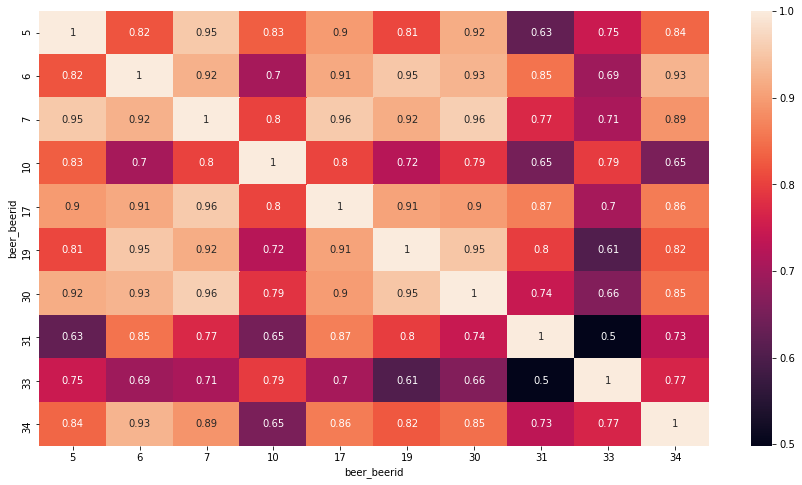

In [137]:
# Plotting Correlation plot
plt.figure(figsize=(15,8))
sns.heatmap(first_10_beer.corr(),annot=True)
plt.show()

- **From the above graph:**
   - All the first 10 are highly correlated with beerid ->5 with greater than or equal to 63% correlation value
   - Beerid 33 is 50% correlated with beer id 31 and this is the least value from above

### Evaluation
- Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the beer already rated by the user insead of predicting it for the beer not rated by the user.

### Using User Similarity

In [139]:
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[ 1.          0.          0.4738041  ...  0.01564531  0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.01344312
   0.        ]
 [ 0.4738041   0.          1.         ...  0.         -0.0261584
   0.        ]
 ...
 [ 0.01564531  0.          0.         ...  1.         -0.00254259
   0.        ]
 [ 0.          0.01344312 -0.0261584  ... -0.00254259  1.
  -0.00305683]
 [ 0.          0.          0.         ...  0.         -0.00305683
   1.        ]]


In [140]:
# Replacing negative correlated values with 0
test_user_correlation[test_user_correlation<0]=0
# Taking dot product
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[1.2252903 , 2.55368922, 1.38543188, ..., 0.46174421, 1.51916794,
        0.00890379],
       [0.38766461, 6.48413849, 0.90984372, ..., 0.53241308, 0.82782175,
        1.21376156],
       [1.72900407, 2.03619015, 0.48121799, ..., 0.19668773, 0.80785651,
        0.0311242 ],
       ...,
       [1.4343257 , 1.59535172, 0.36780886, ..., 0.79025606, 0.79689358,
        0.31573531],
       [0.48784051, 2.26362035, 1.27755403, ..., 0.59921128, 1.16690972,
        0.66607578],
       [0.3436973 , 1.09402566, 0.3491082 , ..., 2.31234641, 1.02302905,
        0.33705976]])

### Doing prediction for the beers rated by the user

In [141]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [142]:
test_user_final_rating.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.266146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,6.484138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3Vandoo,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4000qtrap,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4DAloveofSTOUT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [143]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

# Applying scaling to normalise the data between 1 to 5
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 2.09058411        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [144]:
test_ = test.pivot(index='review_profilename',columns='beer_beerid',values='review_overall')

In [145]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [146]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.7683213660965242


### Using Item similarity

In [147]:
# Evaluating Item similarity
test_beer_features = test.pivot(index='review_profilename',columns='beer_beerid',values='review_overall').T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [148]:
test_item_correlation.shape

(1328, 1328)

In [149]:
test_beer_features.shape

(1328, 2186)

In [150]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,67219,68958,68960,69070,69363,70910,71405,72138,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
1759Girl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.502438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,3.772817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3Vandoo,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4000qtrap,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4DAloveofSTOUT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
test_ = test.pivot(index='review_profilename',columns='beer_beerid',values='review_overall')

In [152]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


### Finding RMSE

In [153]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.007071451594514


- We got RMSE 1.7697 for User based and 2.0022 for Item based model.
- So, User based recommendations is good for deployment in real time.

### Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

- **User Based **

In [154]:
# For Cokes User based
cokes_user = pd.DataFrame(user_final_rating[user_final_rating.index=='cokes']).T
cokes_user.sort_values(by='cokes',ascending=False)[:5]

review_profilename,cokes
beer_beerid,
412,33.315112
2093,33.228753
645,31.983916
1904,31.314172
34,30.864219


In [155]:
# For genog User based
genog_user = pd.DataFrame(user_final_rating[user_final_rating.index=='genog']).T
genog_user.sort_values(by='genog',ascending=False)[:5]

review_profilename,genog
beer_beerid,
2093,36.838724
276,36.566764
412,35.889610
1708,34.996842
1093,33.643782


In [156]:
# For giblet User based
giblet_user = pd.DataFrame(user_final_rating[user_final_rating.index=='giblet']).T
giblet_user.sort_values(by='giblet',ascending=False)[:5]

review_profilename,giblet
beer_beerid,
412,36.479292
1093,33.832770
2093,33.801178
1708,33.347519
1013,32.810871


- For User based Recommendations:
    All the 3 users has common beerid 412 and 2093

- **item Based **

In [157]:
# For Cokes Item
cokes_item = pd.DataFrame(item_final_rating[user_final_rating.index=='cokes']).T
cokes_item.sort_values(by='cokes',ascending=False)[:5]

review_profilename,cokes
beer_beerid,
6549,11.657030
38365,11.355482
101,11.289577
2595,11.258220
43491,11.041370


In [158]:
# For genog item
genog_item = pd.DataFrame(item_final_rating[user_final_rating.index=='genog']).T
genog_item.sort_values(by='genog',ascending=False)[:5]

review_profilename,genog
beer_beerid,
12068,5.897331
13906,5.501763
1504,5.447426
2751,5.374738
47434,5.314009


In [159]:
# For giblet item
giblet_item = pd.DataFrame(item_final_rating[user_final_rating.index=='giblet']).T
giblet_item.sort_values(by='giblet',ascending=False)[:5]

review_profilename,giblet
beer_beerid,
781,5.115461
1256,5.022207
1552,4.891184
27804,4.881822
206,4.780963


- For Item based :
    All the 3 users has nothing in common 